# Audio Scene Classification for Binaural Ensembles
## Data generation and model building

**Table of Content**

1. HRIR Preparation
    - Store all HRIR in ***hrir_array***, and store the sample rate in ***hrir_sr***
    - Print List of HRIR files, and display audio for checking
2. HRIR Vector Preparation
    - Create ***hrir_vector*** to store the azimuth and elevation of corresponding HRIR files in ***hrir_array***
3. VBAP Panner Class
    - Detailed description in the class cell


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, glob
import soundfile as sf # <-- read audio
from scipy.spatial import ConvexHull
import librosa # <-- resample function
from scipy import signal # <-- fast convolution function
from IPython.display import Audio # <-- Audio listening in notebook
import copy

### 1. HRIR Preparation

In [8]:
source_dir = 'Test_MIR/*.wav'
hrtf_dir_MIT = 'HRIR_VBAP/*.wav'

_SOURCES = glob.glob(source_dir)
_MIT = glob.glob(hrtf_dir_MIT)

_SOURCES.sort()
_MIT.sort()

In [3]:
# Run this for a rundown of HRTF sets available and 
# their index to use in a function
print('List of HRTF files:')
for s in range(len(_MIT)):
    print('\033[1m' + str(s) +'. ' + '\033[0m' + _MIT[s][13:]) 

List of HRTF files:
0. H-30e000a.wav
1. H-30e030a.wav
2. H-30e060a.wav
3. H-30e090a.wav
4. H-30e120a.wav
5. H-30e150a.wav
6. H-30e180a.wav
7. H-30e210a.wav
8. H-30e240a.wav
9. H-30e270a.wav
10. H-30e300a.wav
11. H-30e330a.wav
12. H0e015a.wav
13. H0e045a.wav
14. H0e075a.wav
15. H0e105a.wav
16. H0e135a.wav
17. H0e165a.wav
18. H0e195a.wav
19. H0e215a.wav
20. H0e245a.wav
21. H0e275a.wav
22. H0e305a.wav
23. H0e335a.wav
24. H30e000a.wav
25. H30e030a.wav
26. H30e060a.wav
27. H30e090a.wav
28. H30e120a.wav
29. H30e150a.wav
30. H30e180a.wav
31. H30e210a.wav
32. H30e240a.wav
33. H30e270a.wav
34. H30e300a.wav
35. H30e330a.wav
36. H90e000a.wav
37. H-90e000a.wav


In [4]:
hrir_array = []
hrir_sr = 0
for i in range(38):
    [HRIR,fs_H] = sf.read(_MIT[i])
    hrir_sr = fs_H
    hrir_array.append(HRIR)

In [5]:
#Play HFTF for checking
for i in range(38):
    print('HRTF' + str(i) + ':')
    display(Audio(hrir_array[i].transpose(),rate=fs_H))

HRTF0:


HRTF1:


HRTF2:


HRTF3:


HRTF4:


HRTF5:


HRTF6:


HRTF7:


HRTF8:


HRTF9:


HRTF10:


HRTF11:


HRTF12:


HRTF13:


HRTF14:


HRTF15:


HRTF16:


HRTF17:


HRTF18:


HRTF19:


HRTF20:


HRTF21:


HRTF22:


HRTF23:


HRTF24:


HRTF25:


HRTF26:


HRTF27:


HRTF28:


HRTF29:


HRTF30:


HRTF31:


HRTF32:


HRTF33:


HRTF34:


HRTF35:


HRTF36:


HRTF37:


### 2. HRIR Vector Preparation

In [6]:
#set loud speaker array
ls_az = np.concatenate((np.arange(0, 360, 30),np.arange(15, 360, 30), np.arange(0, 360, 30), np.zeros(2)))
print('Azimuth cordinates for the speaker array:')
print(ls_az)
print('Dimensions for azimuth cordinates:')
print(ls_az.shape)
print('')
ls_ele = np.concatenate((np.ones(12)* -30, np.zeros(12), np.ones(12)* 30, np.array([90, -90])))
print('Elevation cordinates for the speaker array:')
print(ls_ele)
print('Dimensions for elevation cordinates:')
print(ls_ele.shape)

Azimuth cordinates for the speaker array:
[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330.  15.  45.
  75. 105. 135. 165. 195. 225. 255. 285. 315. 345.   0.  30.  60.  90.
 120. 150. 180. 210. 240. 270. 300. 330.   0.   0.]
Dimensions for azimuth cordinates:
(38,)

Elevation cordinates for the speaker array:
[-30. -30. -30. -30. -30. -30. -30. -30. -30. -30. -30. -30.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  30.  30.  30.  30.
  30.  30.  30.  30.  30.  30.  30.  30.  90. -90.]
Dimensions for elevation cordinates:
(38,)


In [9]:
# Organize angular coodinates in hrir_vector
hrir_vector = np.vstack([ls_az,ls_ele]).transpose()

### 3. VABP Panner Class

In [10]:
class vbap_panner():
    """Description
    
    Variables
    ----------
    self.hrir_array : np.array, shape=(n, m, 2)
        n = number of speaker array used
        m = length of each HRIR file (one channel)
        2 = number of channels
        HRIR for each speaker position

    self.hrir_sr : int
        Sample rate of HRIR files

    self.hrir_vector : np.array, shape=(n, 2)
        n = number of speaker array used
        2 = azimuth and elevation angle (0 to 360)
        Azimuth and elevation coordinates for each HRIR
        
    self.hrir_vector_cartesion : np.array, shape=(n, 3)
        The [x, y, z] coordinates of each HRIR Vector 
        
    self.triangles : np.arry, shape=(n, 3)
        The indexes of the three speaker vectors in every triangles in the sphere

    Returns
    -------
    vbap_panner class object

    """
    # initialization
    def __init__(self, hrir_array, hrir_sr, hrir_vector):
        # check size
        # if(hrir_array.shape()[0] != hrir_vector.shape()[0]):
          # SHOW ERROR MESSAGE

        self.hrir_array = hrir_array
        self.hrir_sr = hrir_sr
        self.hrir_vector = hrir_vector

        number_of_speakers = len(hrir_vector)

        # create np.array, shape=(number_of_speakers, 3)
        self.hrir_vector_cartesion = np.zeros((number_of_speakers, 3))
        #for each n, compute cartesion fromo angular
        for i in range(number_of_speakers):
            self.hrir_vector_cartesion[i, :] = self.ang_to_cart(hrir_vector[i][0], 
                                                      hrir_vector[i][1])

        # get all triangles around the sphere, and store the speaker's indexes into an array
        self.triangles = ConvexHull(self.hrir_vector_cartesion).simplices
        return

    # spatialize HRIR to correct position in space
    def spatialize(self, sig, sig_sr, azimuth, elevation):

        # force signal to be mono
        if len(sig.shape)==1:
            sig_mono = sig
        elif len(sig.shape)==2:
            sig_mono = np.mean(sig,axis=1)
        else:
            print("Wrong signal dimension.")
            return

        if sig_sr != self.hrir_sr:
            sig_mono_resampled = librosa.core.resample(sig_mono.transpose(),sig_sr,self.hrir_sr)
        else:
            sig_mono_resampled = sig_mono

        source_vector_cartesion = self.ang_to_cart(azimuth, elevation)
        gains, ls_index = self.find_active_triangles(source_vector_cartesion)

        # Convolve --> Frequency domain is faster
        L_out = np.zeros(len(sig_mono_resampled)+ self.hrir_array[0].shape[0]-1)
        R_out = np.zeros(len(sig_mono_resampled)+ self.hrir_array[0].shape[0]-1)

        for i in range(3):
          # spatialized source for Left channel
            HRIR_index = ls_index[i]
            L_out +=  signal.fftconvolve(sig_mono_resampled,
                      self.hrir_array[HRIR_index][:, 0].T) * gains[i]
            # spatialized source for Right channel
            R_out += signal.fftconvolve(sig_mono_resampled,
                      self.hrir_array[HRIR_index][:, 1].T) * gains[i]


        Bin_Mix = np.vstack([L_out,R_out]).transpose()
        Bin_Mix = Bin_Mix/np.max(np.abs(Bin_Mix))
        # print('Data Dimensions: ', Bin_Mix.shape) 
        return Bin_Mix 

# Utility Functions:
    # angular to cartesian codinates
    def ang_to_cart(self, azi, ele):
        ele_rad = ele / 360 * 2 * np.pi
        azi_rad = azi / 360 * 2 * np.pi
        x = np.cos(ele_rad) * np.cos(azi_rad)
        y = np.cos(ele_rad) * np.sin(azi_rad)
        z = np.sin(ele_rad)
        return np.array([x, y, z])

    # calculate gain for triangle  
    def calc_gain(self, base, p_cart):
        gains = np.linalg.solve(base, p_cart)
        return gains

    # narmalized gain
    def normalize(self, gains, norm):
        return gains * np.sqrt(norm / np.sum(gains ** 2))

    # find active speaker triangle
    def find_active_triangles(self, p_cart):
        base = np.zeros((3,3))
        for i in range(len(self.triangles)):
            ls_index = self.triangles[i]
            for j in range(3):
                base[:, j] = self.hrir_vector_cartesion[ls_index[j], :]
      
            gains = self.calc_gain(base, p_cart)
            if np.min(gains)>=0:
                gains = self.normalize(gains, 1)
                print("Indexes of speaker array used:"+ str(ls_index))
                break  
        return gains, ls_index     

### 4. Random Locations

In [11]:
import random

In [12]:
def random_generater (num_examples, center_array, width, max_num_tracks,
                      region_seed = 3, angle_seed = 9):
    """Description

    Variables
    ----------
    num_examples : int
        Number of examples

    center_array : np.array, shape=(n,)
        n = number of centers
        Centers'azimuth angles on the elevation 0 plane

    width : int
        Width reletive to centers

    max_num_tracks : int
        Maximum number of tracks in an Ensemble

    Returns
    -------


    """
    array = np.full(shape=(num_examples, 1+max_num_tracks), fill_value=-1, 
                  dtype=int)
    rand_reg = random.Random(region_seed)
    rand_ang = random.Random(angle_seed)

    for i in range(num_examples):
        idx = rand_reg.randint(0, len(center_array)-1)
        array[i][0] = center_array[idx]

        for j in range(1, 1+max_num_tracks):
            array[i][j] = rand_ang.randint(width * -1, width)

    return array

### 5.0 TEST: 8 location - 1 song - 0 width - 1 track (mix)

In [ ]:
num_examples = 1000
center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
width = 0
max_num_tracks = 1

source_locations = random_generater(num_examples, center_array, width, max_num_tracks)
print(source_locations)

### 5.1 TEST: 8 location - 1 song - Increased width - 1 track (mix)

In [ ]:
num_examples = 1000
center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
width = 20
max_num_tracks = 1

source_locations = random_generater(num_examples, center_array, width, max_num_tracks)
print(source_locations)

In [ ]:
panner = vbap_panner(hrir_array, hrir_sr, hrir_vector)

duration = 3
sig_dir = _SOURCES[2]
[sig, sig_sr] = sf.read(sig_dir)
sig_truncated = sig[sig_sr*duration*3:sig_sr*duration*4 ,]

In [ ]:
for i in range(5):
    azi = source_locations[i][0] + source_locations[i][1]
    ele = 0
    print("Azimuth: " +str(azi) + ", Elevation: 0")
    Bin_Mix = panner.spatialize(sig_truncated, sig_sr, azi, ele)
    display(Audio(Bin_Mix.T, rate=panner.hrir_sr))

### 5.2 TEST: 8 location - 9 song - increased width - 1 track (mix)

In [26]:
# preparing signals
panner = vbap_panner(hrir_array, hrir_sr, hrir_vector)
duration = 3

sig_array = []
sig_sr = 0

for i in range(9):
    sig_dir = _SOURCES[i]
    [sig, sig_sr] = sf.read(sig_dir)
    sig_truncated = sig[sig_sr*duration*3:sig_sr*duration*4 ,]
    sig_array.append(sig_truncated)
    
print(len(sig_array))
print(sig_sr)

9
16000


In [27]:
num_examples = 1000
center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
width = 20
max_num_tracks = 1

source_locations = random_generater(num_examples, center_array, width, max_num_tracks)
print(source_locations)

[[135   9]
 [ 90  19]
 [225   3]
 ...
 [ 45   0]
 [225   2]
 [315 -11]]


In [28]:
for i in range(5):
    azi = source_locations[i][0] + source_locations[i][1]
    ele = 0
    print("Azimuth: " +str(azi) + ", Elevation: 0")
    Bin_Mix = panner.spatialize(sig_array[i%len(sig_array)], sig_sr, azi, ele)
    display(Audio(Bin_Mix.T, rate=panner.hrir_sr))

Azimuth: 144, Elevation: 0
Indexes of speaker array used:[16 17 29]


Azimuth: 109, Elevation: 0
Indexes of speaker array used:[16 28 15]


Azimuth: 228, Elevation: 0
Indexes of speaker array used:[20 19 32]


Azimuth: 312, Elevation: 0
Indexes of speaker array used:[22 10 21]


Azimuth: 33, Elevation: 0
Indexes of speaker array used:[13 25 12]


In [ ]:
# panner = vbap_panner(hrir_array, hrir_sr, hrir_vector)

# duration = 15
# for i in range(len(_SOURCES)):
#     sig_dir = _SOURCES[i]
#     [sig, sig_sr] = sf.read(sig_dir)
#     sig_truncated = sig[0:sig_sr*duration,]
#     print(str(i))
#     azi = i*45
#     ele = 0
#     print("Azimuth: " +str(azi) + ", Elevation: 0")
#     Bin_Mix = panner.spatialize(sig_truncated, sig_sr, azi, ele)
#     display(Audio(Bin_Mix.T, rate=panner.hrir_sr))
#     sf.write(str(i) + "_Az" +str(azi) + "_Ele0.wav",Bin_Mix,panner.hrir_sr)

### 6. Preprocessing

In [29]:
dataset = []

for i in range(500):
    azi = source_locations[i][0] + source_locations[i][1]
    ele = 0
    print(str(i) + ":")
    print("Azimuth: " +str(azi) + ", Elevation: 0")
    Bin_Mix = panner.spatialize(sig_array[i%len(sig_array)], sig_sr, azi, ele)
    # print(Bin_Mix.shape)
    
    features_L = librosa.feature.melspectrogram(y=Bin_Mix[:, 0], sr=panner.hrir_sr)
    features_R = librosa.feature.melspectrogram(y=Bin_Mix[:, 1], sr=panner.hrir_sr)
    
    features = np.zeros((features_L.shape[0], features_L.shape[1], 2))
    features[:, :, 0] = features_L
    features[:, :, 1] = features_R
    # print(features_left.shape)
    
    dataset.append(features)
    
dataset = np.array (dataset)

print(dataset.shape)

0:
Azimuth: 144, Elevation: 0
Indexes of speaker array used:[16 17 29]
1:
Azimuth: 109, Elevation: 0
Indexes of speaker array used:[16 28 15]
2:
Azimuth: 228, Elevation: 0
Indexes of speaker array used:[20 19 32]
3:
Azimuth: 312, Elevation: 0
Indexes of speaker array used:[22 10 21]
4:
Azimuth: 33, Elevation: 0
Indexes of speaker array used:[13 25 12]
5:
Azimuth: -9, Elevation: 0
Indexes of speaker array used:[23  0 12]
6:
Azimuth: 295, Elevation: 0
Indexes of speaker array used:[22 10 21]
7:
Azimuth: 181, Elevation: 0
Indexes of speaker array used:[17  6 18]
8:
Azimuth: 147, Elevation: 0
Indexes of speaker array used:[16 17 29]
9:
Azimuth: 144, Elevation: 0
Indexes of speaker array used:[16 17 29]
10:
Azimuth: 333, Elevation: 0
Indexes of speaker array used:[22 23 11]
11:
Azimuth: 300, Elevation: 0
Indexes of speaker array used:[22 10 21]
12:
Azimuth: 271, Elevation: 0
Indexes of speaker array used:[20 33 21]
13:
Azimuth: 105, Elevation: 0
Indexes of speaker array used:[16 28 15]
14:


### 7. Baseline Classifier: 1 conv unit - 1 dense unit

In [18]:
# Import library
# from tensorflow import keras
# from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

2023-02-21 08:42:25.165282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Build the model
# Define the number of classes
num_classes = 8

# Define the input shape
input_shape = (128,259,2)

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# Flatten the output of the convolutional layers
model.add(Flatten())
model.add(BatchNormalization())

# Add the first dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [37]:
# train test split, nomalize, reshape
features_train = dataset[:299]
features_test = dataset[300:399]

# features_train = features_train[..., np.newaxis]
# features_test = features_test[..., np.newaxis][..., np.newaxis]

# features_train_r2 = features_train/np.amax(np.absolute(features_train))
# features_train_r2 = features_train_r2.reshape((features_train_r2.shape[0], 
#                                                features_train_r2.shape[1] * features_train_r2.shape[2]))

# features_test_r2 = features_test/np.amax(np.absolute(features_train))
# features_test_r2 = features_test_r2.reshape((features_test_r2.shape[0], 
#                                              features_test_r2.shape[1] * features_test_r2.shape[2]))

# print(np.amax(features_train_r2))
# print(np.amax(features_test_r2))
# print(np.amax(np.absolute(features_train)))
# print(np.amax(np.absolute(features_test)))

labels = source_locations[:, 0]

labels_train = labels[:299] / 45
labels_test = labels[300:399] / 45

# print(labels_train)

In [32]:
# train model
# Train the model for a specified number of epochs
num_epochs = 10
batch_size = 16
model.fit(features_train, labels_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
19/19 [==============================] - 3s 117ms/step - loss: 4.5959 - accuracy: 0.3344
Epoch 2/10
19/19 [==============================] - 2s 113ms/step - loss: 3.4851 - accuracy: 0.4682
Epoch 3/10
19/19 [==============================] - 2s 113ms/step - loss: 2.4052 - accuracy: 0.5853
Epoch 4/10
19/19 [==============================] - 2s 115ms/step - loss: 2.2235 - accuracy: 0.6522
Epoch 5/10
19/19 [==============================] - 2s 115ms/step - loss: 2.0103 - accuracy: 0.6722
Epoch 6/10
19/19 [==============================] - 2s 114ms/step - loss: 1.8786 - accuracy: 0.7224
Epoch 7/10
19/19 [==============================] - 2s 117ms/step - loss: 1.3955 - accuracy: 0.7291
Epoch 8/10
19/19 [==============================] - 2s 113ms/step - loss: 1.6365 - accuracy: 0.7224
Epoch 9/10
19/19 [==============================] - 2s 116ms/step - loss: 1.4795 - accuracy: 0.7425
Epoch 10/10
19/19 [==============================] - 2s 116ms/step - loss: 1.9195 - accuracy: 0.7492

In [43]:
# pridiction analysis
predictions = model.predict(features_test)
print(predictions[0])

print(labels_test[0])

4/4 [==============================] - 0s 40ms/step
[9.5268321e-01 3.9390560e-02 3.2034040e-07 7.3254523e-03 6.0040003e-04
 4.2246217e-08 5.1891252e-11 7.7296985e-10]
1.0


In [44]:
test_loss, test_acc = model.evaluate(features_test, labels_test)
print(f"test_acc: {test_acc}")

4/4 [==============================] - 0s 37ms/step - loss: 1.7259 - accuracy: 0.6566
test_acc: 0.6565656661987305


In [49]:
y_true = labels_test
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))
    
print(y_pred)


[0, 6, 1, 0, 6, 3, 0, 1, 0, 4, 4, 1, 0, 3, 1, 1, 0, 5, 2, 0, 3, 2, 4, 6, 6, 4, 5, 5, 5, 6, 1, 6, 3, 6, 2, 5, 7, 0, 6, 1, 2, 3, 6, 7, 7, 2, 0, 0, 3, 2, 6, 3, 4, 6, 4, 3, 0, 0, 4, 6, 6, 3, 2, 5, 0, 6, 7, 2, 6, 6, 3, 7, 4, 7, 1, 6, 4, 6, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 0, 4, 3, 0, 0, 1, 6, 3, 3, 1, 4]


In [50]:
import sklearn as sk

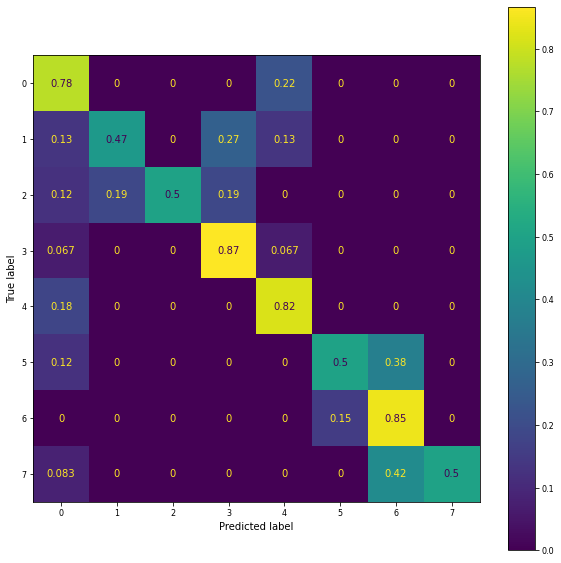

In [57]:


cm = sk.metrics.confusion_matrix(y_true, y_pred, normalize = 'true')
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
plt.show(disp)

### Future Work
- Finish the Data Generation Pipeline
    - Input:
        - /Dataset/Examples/Stems
        - Azimuth locations ([0, 45, 90, 135, 180, 225, 270, 315])
        - Width (Location for each stem = Azimuth location +- Width/2)
    - Output
        - Binuaralized Examples
        - Location label, dimension? how to store?
- Use Slakh Library to generate a protype dataset
    - Use Mirdata?
        - Multitrack object?